# Setup

In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 0s (3,036 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-

In [1]:
!pip install osmnx

## Exercises
- identify the shortest path by walk to reach the Castle of Trento from the main train station
- identify how many bars you can reach by walking in 5 minutes from the main train station of Trento

# identify the shortest path by walk to reach the Castle of Trento from the main train station
- where is the castle in Trento
- where is the main train station

## where is the castle in Trento
THe name of the castle of Trento is *Castello del Buonconsiglio*

https://en.wikipedia.org/wiki/Buonconsiglio_Castle



In [2]:
from geopy.geocoders import Nominatim

In [3]:
geolocator = Nominatim(user_agent="geospatial course")
location = geolocator.geocode("Castello del Buonconsiglio")

In [4]:
point_castle =  (location.latitude, location.longitude)

## where is the main train station in Trento?

https://en.wikipedia.org/wiki/Trento_railway_station

In [5]:
location = geolocator.geocode("Trento stazione fs")

In [6]:
point_train_station =  (location.latitude, location.longitude)

## create the streets walking graph

In [7]:
import osmnx as ox

In [8]:
G = ox.graph_from_place("Trento, Italy", network_type='walk')

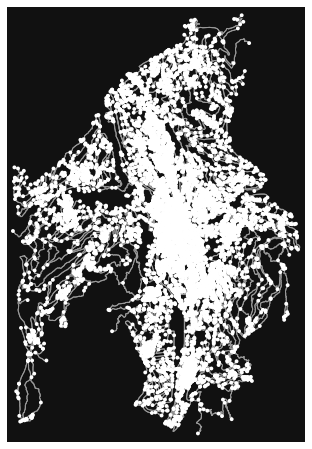

In [9]:
fig, ax = ox.plot_graph(G)

## identify the shortest path

the points must connetected to the graph

In [10]:
point_nearest_train_station= ox.get_nearest_node(G, point_train_station)
point_nearest_castle = ox.get_nearest_node(G, point_castle)

### calculate the shortest path ;)

we use [K shortest path routing](https://en.wikipedia.org/wiki/K_shortest_path_routing) [implemented in OSMnx](k_shortest_paths)

*k=1* we assume to use the first 

In [11]:
route = ox.k_shortest_paths(G, point_nearest_train_station, point_nearest_castle, k=1, weight='length')

In [12]:
route = list(route)[0]

### show it on the map 



In [13]:
ox.plot_route_folium(G,route,popup_attribute='name',tiles='OpenStreetMap')

*route* contains a list of nodes id of the Graph (*G*)

In [14]:
route

[2591984564,
 885670129,
 1271504902,
 877620756,
 256547316,
 247792032,
 1156723779,
 939851139,
 2390597889,
 247792029,
 1298727142,
 959911004,
 889555297,
 892578959,
 445811740,
 889555354,
 889555637,
 1492679675,
 1492679687,
 1492679714,
 1492679733,
 888452709,
 1492679729,
 2477480071,
 1271504889,
 1755063751,
 1252285137,
 955281037,
 1252285107,
 1252285133,
 2889611593,
 6036162196,
 6036162193,
 858341167,
 858341204]

for example *2591984564*

In [15]:
G.nodes[2591984564]

{'osmid': 2591984564, 'x': 11.1195324, 'y': 46.0720446}

In [16]:
G.nodes[2591984564]['x']

11.1195324

how obtain a LineString of from these ids

In [17]:
from shapely.geometry import Point,LineString

In [18]:
points = []
for idnode in route:
  lon = G.nodes[idnode]['x']
  lat = G.nodes[idnode]['y']
  point = Point(lon,lat)
  points.append(point)

In [19]:
path = LineString(points)

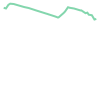

In [20]:
path

.. and manage it in geopandas

In [21]:
import geopandas as gpd

In [22]:
data = {'name': ['from train station to the castle'], 'geometry': [path]}

In [23]:
gdf_path = gpd.GeoDataFrame(data,crs="EPSG:4326") 

In [24]:
gdf_path.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
gdf_path

,name,geometry
0,from train station to the castle,"LINESTRING (11.11953 46.07204, 11.11957 46.072..."


<AxesSubplot:>

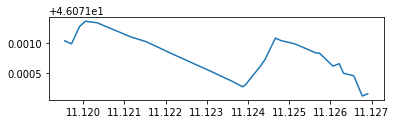

In [26]:
gdf_path.plot()

In [27]:
gdf_path.to_file("path_trainstation2castle_trento.geojson", driver="GeoJSON")

In [28]:
#uncomment if you are using Colab
#from google.colab import files
#files.download("path_trainstation2castle_trento.geojson")

# identify how many bars you can reach by walking in 5 minutes from the main train station of Trento

OpenStreetMap distingues between [bar](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dbar) and [cafe](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dcafe).<br/>
In Italy the difference is minimal, so we have to extract the data from both sources

The steps are:

- download all the *amenity=bar* and *amenity=cafe* from OpenStreetMap
- identify the point of the train station
- calculate the distance of each bar from the train station in walking travel time distance 

## download all the amenity=bar  and amenity=cafe from OpenStreetMap

with osmnx

In [29]:
tags = {'amenity': ['bar','cafe']}

In [30]:
trento_bars = ox.geometries_from_place("Trento",tags)

In [31]:
trento_bars.shape

(260, 71)

In [32]:
print("In OpenStreetMap, for the city or Trento, there are a total of %s of tags with amenity=bar and amenity=cafe" % str(trento_bars.shape[0]))

In OpenStreetMap, for the city or Trento, there are a total of 260 of tags with amenity=bar and amenity=cafe


the total is

## check the bar nearest by distance to the train stations

identify the linear distance (no street network)

transform the coordinates of the train station from degrees (WGS84 - EPSG:4326) to meters (UTM 32N - EPSG:32632) to calculate the distance

In [33]:
from shapely.ops import transform
import pyproj

In [34]:
wgs84 = pyproj.CRS('EPSG:4326')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

In [35]:
shapely_point_train_station = Point(point_train_station)

In [36]:
point_train_station_utm32n = transform(projection_transform,shapely_point_train_station)

and now we have the new point in epsg:32632

In [37]:
point_train_station_utm32n.wkt

'POINT (663888.6956006237 5104257.577081034)'

we want calculate the distance point to point so we need to know the type of geometry in our geodataframe (*trento_bars*)

In [38]:
trento_bars.geometry.type.unique()

array(['Point', 'Polygon'], dtype=object)

In [39]:
trento_bars.geometry.type.value_counts()

Point      251
Polygon      9
dtype: int64

we can calculate the distance to the point of the train station to a representative point of each geometry (so we transform the polygons in points)

Are the distances are calculated in meters (UTM 32N)

In [40]:
trento_bars.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

0      2524.142113
1       518.512766
2       542.515407
3       737.889408
4       686.542193
          ...     
255    2813.859928
256    1554.211774
257    3799.815530
258    1653.311307
259    3378.216513
Length: 260, dtype: float64

... we store the answers in a new column

In [41]:
trento_bars['haversine_distance_to_train_station'] = trento_bars.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

In [42]:
trento_bars.sort_values(by=['haversine_distance_to_train_station']).head(5)

,unique_id,osmid,element_type,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,name,geometry,addr:country,contact:phone,operator,outdoor_seating,ref:vatin,contact:email,wheelchair,fixme,opening_hours,brewery,contact:website,cost:coffee,smoking,source,created_by,addr:number,shop,phone,internet_access,internet_access:fee,surveillance,contact:facebook,contact:tripadvisor,cuisine,contact:mobile,note,website,toilets:wheelchair,alt_name,contact:company,ref:vat_in,contact:name,contact:fax,email,fax,level,wifi,addr:housename,layer,name:en,name:it,diet:vegan,diet:vegetarian,ref:VATIN,ref:vatin_1,entrance,air_conditioning,payment:cash,payment:debit_cards,description,payment:bancomat,payment:coins,payment:notes,operator:addr:city,operator:addr:housenumber,operator:addr:postcode,operator:addr:street,ref:rea,sells:tobacco,nodes,building,haversine_distance_to_train_station
96,node/867377187,867377187,node,Trento,1,38122,Piazza Dante,bar,Bar Stazione Buffet Trento,POINT (11.11946 46.07250),IT,NaN,Serenissima Ristorazione SPA,NaN,IT01617950249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.018800
253,way/73089915,73089915,way,Trento,13,NaN,Piazza Dante,bar,Flora,"POLYGON ((11.12028 46.07245, 11.12027 46.07241...",NaN,NaN,Sali e Tabacchi Riv. N° 23,NaN,NaN,NaN,NaN,NaN,Mo-Sa 06:00-21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tobacco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[867377189, 867377061, 867377184, 867377320, 8...",yes,79.059449
254,way/73293759,73293759,way,NaN,NaN,NaN,NaN,cafe,Bar Caffetteria Dogana,"POLYGON ((11.12085 46.07342, 11.12075 46.07338...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[869314003, 869314081, 869313986, 869314147, 8...",yes,173.832806
97,node/867377209,867377209,node,Trento,2,38122,Via Dogana,bar,Bar Trento-Malé,POINT (11.12038 46.07375),IT,+39 0461 239398,Caset Mariarita,NaN,IT01556070223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.932583
231,node/4264239318,4264239318,node,Trento,30,38122,Piazza Dante,bar,Liber Café,POINT (11.12091 46.07086),IT,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palazzina Liberty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.739151


indentify the nearest point (in linear distance) close to the point of the train station 

In [43]:
trento_bars[trento_bars.haversine_distance_to_train_station == trento_bars.haversine_distance_to_train_station.min()].name.values[0]

'Bar Stazione Buffet Trento'

## find the distance of each bar to the train station


## add the weights of speed and travel time


check documentation [module-osmnx.speed](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.speed)

---

If edge *maxspeed* attribute has *“mph”* in it, value will automatically be converted from miles per hour to km per hour. 

Any other speed units should be manually converted to km per hour prior to running this function, otherwise there could be unexpected results. 

If “mph” does not appear in the edge’s maxspeed attribute string, then function assumes kph, per OSM guidelines: 

https://wiki.openstreetmap.org/wiki/Map_Features/Units

**hwy_speeds** *(dict)* 

*dict keys* = *OSM highway types and values* = typical  speeds (km per hour) to assign to edges of that highway type for any edges missing speed data. 

Any edges with highway type not in hwy_speeds will be assigned the mean preexisting speed value of all edges of that highway type.

---

we can assume from 2.5 to 3.5 km/h of speed where roads designed for pedestrians are faster than those designed only for cars



In [44]:
hwy_walking_speeds = {
    'motorway ': 0.5,
    'trunk': 0.5,
    'primary': 0.5,
    'secondary': 0.5,
    'tertiary': 0.5,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}
G = ox.add_edge_speeds(G,hwy_speeds=hwy_walking_speeds)
G = ox.add_edge_travel_times(G)

In [45]:
point_nearest_train_station= ox.get_nearest_node(G, point_train_station)

we identify a nearest point of each representative point of each location we have to reach

In [46]:
trento_bars['nearest_point_to_graph'] = trento_bars.geometry.representative_point().apply(lambda point: ox.get_nearest_node(G, (point.y,point.x)))

calculate the short path from the train station to each location

In [47]:
trento_bars['route_from_train_station'] = trento_bars.nearest_point_to_graph.apply(lambda to_point: ox.shortest_path(G, point_nearest_train_station, to_point))

create geometry of each path 

In [48]:
# this define the function to create the linestring from the id nodes of the graph
def geometry_from_route(inG,route):
  points = []
  for idnode in route:
    lon = inG.nodes[idnode]['x']
    lat = inG.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  return(LineString(points))

In [49]:
trento_bars['linestring'] = trento_bars.route_from_train_station.apply(lambda route: geometry_from_route(G,route))

Show all the locations



<AxesSubplot:>

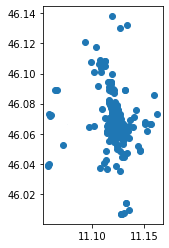

In [50]:
trento_bars.plot()

Show all the paths from the train station to each location

<AxesSubplot:>

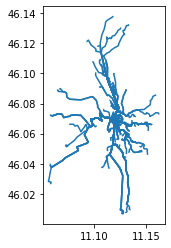

In [51]:
trento_bars.set_geometry('linestring').plot()

calculate time for each path

In [52]:
def travel_time_from_train_station(inG, route):
  edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
  return (sum(edge_times))

In [53]:
trento_bars['travel_time_from_train_station'] = trento_bars.route_from_train_station.apply(lambda route: travel_time_from_train_station(G,route))

and the length for each

In [54]:
def lenght_path_from_train_station(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')
  return (sum(edge_lengths))

In [55]:
trento_bars['path_lenght_from_train_station'] = trento_bars.route_from_train_station.apply(lambda route: lenght_path_from_train_station(G,route))

show the first 5 bars by harvesine distance

In [56]:
trento_bars.sort_values(by=['haversine_distance_to_train_station']).head(5)[['name','haversine_distance_to_train_station']]

,name,haversine_distance_to_train_station
96,Bar Stazione Buffet Trento,31.018800
253,Flora,79.059449
254,Bar Caffetteria Dogana,173.832806
97,Bar Trento-Malé,186.932583
231,Liber Café,196.739151


show the first 5 bars by travel time distance (in seconds)

In [57]:
trento_bars.sort_values(by=['travel_time_from_train_station']).head(10)[['name','travel_time_from_train_station']]

,name,travel_time_from_train_station
96,Bar Stazione Buffet Trento,42.2
253,Flora,101.4
97,Bar Trento-Malé,264.7
168,Giornale & Caffè,269.8
80,Bar Buonconsiglio,321.1
107,Bar Torre Vanga,377.0
254,Bar Caffetteria Dogana,383.4
138,Caffè Al Tempo Perso,408.6
143,BarConad,419.7
32,ENI,441.4


## all the bar reachable in 5 minutes from the train station of Trento

In [58]:
five_minutes_in_seconds = 5*60

In [59]:
five_minutes_in_seconds

300

In [60]:
bars_five_minutes_from_train_station = trento_bars[trento_bars.travel_time_from_train_station <= five_minutes_in_seconds]

In [61]:
bars_five_minutes_from_train_station = bars_five_minutes_from_train_station.sort_values(by=['travel_time_from_train_station'])

In [62]:
bars_five_minutes_from_train_station

,unique_id,osmid,element_type,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,name,geometry,addr:country,contact:phone,operator,outdoor_seating,ref:vatin,contact:email,wheelchair,fixme,opening_hours,brewery,contact:website,cost:coffee,smoking,source,created_by,addr:number,shop,phone,internet_access,internet_access:fee,surveillance,contact:facebook,contact:tripadvisor,cuisine,contact:mobile,note,website,toilets:wheelchair,alt_name,contact:company,ref:vat_in,contact:name,contact:fax,email,fax,level,wifi,addr:housename,layer,name:en,name:it,diet:vegan,diet:vegetarian,ref:VATIN,ref:vatin_1,entrance,air_conditioning,payment:cash,payment:debit_cards,description,payment:bancomat,payment:coins,payment:notes,operator:addr:city,operator:addr:housenumber,operator:addr:postcode,operator:addr:street,ref:rea,sells:tobacco,nodes,building,haversine_distance_to_train_station,nearest_point_to_graph,route_from_train_station,linestring,travel_time_from_train_station,path_lenght_from_train_station
96,node/867377187,867377187,node,Trento,1,38122,Piazza Dante,bar,Bar Stazione Buffet Trento,POINT (11.11946 46.07250),IT,NaN,Serenissima Ristorazione SPA,NaN,IT01617950249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.018800,864509648,"[2591984564, 885670129, 923132120, 864509648]","LINESTRING (11.1195324 46.0720446, 11.119568 4...",42.2,41.043
253,way/73089915,73089915,way,Trento,13,NaN,Piazza Dante,bar,Flora,"POLYGON ((11.12028 46.07245, 11.12027 46.07241...",NaN,NaN,Sali e Tabacchi Riv. N° 23,NaN,NaN,NaN,NaN,NaN,Mo-Sa 06:00-21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tobacco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[867377189, 867377061, 867377184, 867377320, 8...",yes,79.059449,963740221,"[2591984564, 885670129, 1271504902, 877620756,...","LINESTRING (11.1195324 46.0720446, 11.119568 4...",101.4,98.542
97,node/867377209,867377209,node,Trento,2,38122,Via Dogana,bar,Bar Trento-Malé,POINT (11.12038 46.07375),IT,+39 0461 239398,Caset Mariarita,NaN,IT01556070223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.932583,941909429,"[2591984564, 885670129, 923132120, 864509648, ...","LINESTRING (11.1195324 46.0720446, 11.119568 4...",264.7,257.270
168,node/1662768545,1662768545,node,Trento,29/1,38122,Via Clementino Vannetti,bar,Giornale & Caffè,POINT (11.12208 46.07266),IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.432987,975288587,"[2591984564, 885670129, 1271504902, 877620756,...","LINESTRING (11.1195324 46.0720446, 11.119568 4...",269.8,262.236


In [63]:
import datetime

In [66]:
maps = []
texts = []
for index, row in bars_five_minutes_from_train_station.iterrows():
    name = row['name']
    travel_time_from_train_station = row['travel_time_from_train_station']
    minutes = str(datetime.timedelta(seconds=travel_time_from_train_station))
    distance = row['path_lenght_from_train_station']
    route = row['route_from_train_station']
    text = "the bar %s is %s meters from the train station and it's reachable in %s minutes" % (name, str(round(distance)), minutes[3:7])
    texts.append(text)
    maps.append(ox.plot_route_folium(G,route,popup_attribute='name',tiles='OpenStreetMap'))

In [67]:
len(maps)

4

In [68]:
texts[0]

"the bar Bar Stazione Buffet Trento is 41 meters from the train station and it's reachable in 0:42 minutes"

In [70]:
texts[1]

"the bar Flora is 99 meters from the train station and it's reachable in 1:41 minutes"

In [71]:
maps[1]

In [72]:
texts[2]

"the bar Bar Trento-Malé is 257 meters from the train station and it's reachable in 4:24 minutes"

In [74]:
maps[2]

In [75]:
texts[3]

"the bar Giornale & Caffè is 262 meters from the train station and it's reachable in 4:29 minutes"

In [76]:
maps[3]

and if you want share the dataset created you can create a geodaframe to select the columns that you want to share



In [78]:
points = bars_five_minutes_from_train_station[['name','geometry','addr:street','addr:housenumber','addr:city', 'travel_time_from_train_station','path_lenght_from_train_station']].set_geometry("geometry")

In [79]:
points

,name,geometry,addr:street,addr:housenumber,addr:city,travel_time_from_train_station,path_lenght_from_train_station
96,Bar Stazione Buffet Trento,POINT (11.11946 46.07250),Piazza Dante,1,Trento,42.2,41.043
253,Flora,"POLYGON ((11.12028 46.07245, 11.12027 46.07241...",Piazza Dante,13,Trento,101.4,98.542
97,Bar Trento-Malé,POINT (11.12038 46.07375),Via Dogana,2,Trento,264.7,257.270
168,Giornale & Caffè,POINT (11.12208 46.07266),Via Clementino Vannetti,29/1,Trento,269.8,262.236


In [80]:
points['geometry'] = points.geometry.representative_point()

In [81]:
points

,name,geometry,addr:street,addr:housenumber,addr:city,travel_time_from_train_station,path_lenght_from_train_station
96,Bar Stazione Buffet Trento,POINT (11.11946 46.07250),Piazza Dante,1,Trento,42.2,41.043
253,Flora,POINT (11.12030 46.07243),Piazza Dante,13,Trento,101.4,98.542
97,Bar Trento-Malé,POINT (11.12038 46.07375),Via Dogana,2,Trento,264.7,257.270
168,Giornale & Caffè,POINT (11.12208 46.07266),Via Clementino Vannetti,29/1,Trento,269.8,262.236


show the all the points on a map

In [84]:
import folium

In [85]:
y = points.geometry.unary_union.centroid.y
x = points.geometry.unary_union.centroid.x
geojson = points.to_json()

In [86]:
map = folium.Map([y,x], zoom_start=16)
folium.GeoJson(geojson).add_to(map)
map


... and create a json to distribute

In [94]:
points.to_file("bar_5_min_to_train_station.geojson",driver="GeoJSON")